In [58]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get Floating Car Tracks

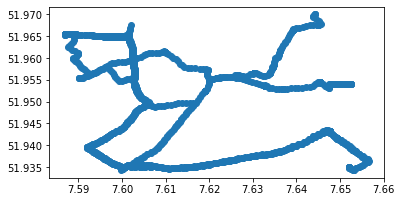

In [59]:
from shapely.geometry import *

bbox = BboxSelector([
            7.598676681518555,
            51.95045473660811,
            7.624168395996093,
            51.965899201787714
        ])
# Requesting a single track
track_df = track_api.get_tracks(bbox=bbox, num_results=10)
track_df.plot()

### Load OSM graph

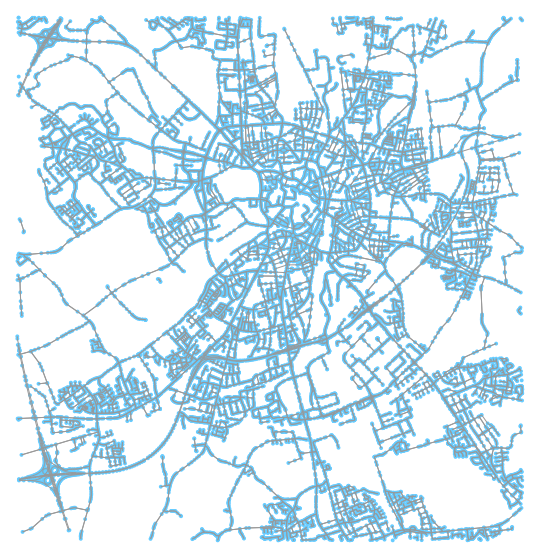

CPU times: user 10.2 s, sys: 244 ms, total: 10.4 s
Wall time: 18.9 s


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a31b5b9d0>)

In [60]:
%%time
import numpy as np
import osmnx as ox

lat = 51.950296032982756
lng = 7.615756988525391

# Get the OSM graph of "drive" streets for münster an plot it
graph = ox.graph.graph_from_bbox(51.9925, 
    51.9045, 
    7.6891, 
    7.551165771484375 , network_type='drive',simplify=False, retain_all=True)
#graph = ox.graph_from_point((lat, lng), dist=10000, network_type='drive')
ox.plot_graph(graph, fig_height=10, fig_width=10)

## Map Matching Example

In [62]:
import mapmatching as mm

some_track_id = track_df['track.id'].unique()[2]
some_track = track_df[track_df['track.id'] == some_track_id]
# Get the latitude and longitude coordinates from the track and join them in an array
lats = list(some_track['geometry'].apply(lambda coord: coord.y))
lngs = list(some_track['geometry'].apply(lambda coord: coord.x))
track_coords = [c for c in zip(lats, lngs)]

streetmap = mm.get_InMemMap(graph)
edge_ids, last_idx, track_corr, route = mm.match(track_coords, graph, streetmap)

mm.plot_html(track_coords, track_corr=track_corr, route_corr=route,
          proj=True, show_graph=True)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Extract coordinates

In [63]:
%%time

track_coords = []
tracks = []
for idx in track_df['track.id'].unique():
    #some_track_id = track_df['track.id'].unique()[5]
    some_track = track_df[track_df['track.id'] == idx]
    tracks.append(some_track)

    # Get the latitude and longitude coordinates from the track and join them in an array
    lats = list(some_track['geometry'].apply(lambda coord: coord.y))
    lngs = list(some_track['geometry'].apply(lambda coord: coord.x))

    track_coord = [c for c in zip(lats, lngs)]
    track_coords.append(track_coord)

    #some_track.plot()

CPU times: user 139 ms, sys: 5.27 ms, total: 144 ms
Wall time: 350 ms


### Mapmatching

In [64]:
%%capture output

import mapmatching as mm
edgeset = None
# get InMem Map
streetmap = mm.get_InMemMap(graph)
for coords, track in zip(track_coords, tracks):
    # map tracks
    edge_ids, last_idx, track_corr, route = mm.match(coords, graph, streetmap)
    st_nodes = []
    end_nodes = []
    max_speed = []
    track_ids = []
    
    # referenced other values to the corresponding point
    for i in edge_ids[:last_idx + 1]:
        st_nodes.append(i[0])
        end_nodes.append(i[1])
        track_ids.append(track['id'][0])

        try:
            max_speed.append(float(graph.edges[(i[0],i[1],0)]['maxspeed']))
        except:
            max_speed.append(0)
    
    track = track[:last_idx + 1]
    track['track_id'] = track_ids
    track['st_nodes'] = st_nodes
    track['end_nodes'] = end_nodes
    track['max_speed'] = max_speed
    
    #Construct a new dataframe
    track = pd.DataFrame({'track_id':track['track_id'], 'st_node': track["st_nodes"], 'end_node': track["end_nodes"], 'speed':track["Speed.value"], 'time':track["time"], 'speed_limit': track["max_speed"], 'CO2':track["CO2.value"]})
    
    # construct the whole dataset
    if edgeset is None:
        edgeset = track
    else:
        edgeset = pd.concat([edgeset,track], ignore_index=True)

## Traffic quality 

In [65]:
from traffics import *

data = edgeset
data = waiting_cars(data, 5)
plot_stat(data, col = 'waiting')

### Segment based speed aggregation

In [66]:
import aggregation as agr

edgeset = agr.aggregateStatsFromNodes(track,col = 'speed')
edgeset = agr.appendNodeCoords(edgeset)
speed = agr.plotAggregatedStatistics(edgeset,col = 'speed')
speed

### Segment based speed limits

In [67]:
edgeset = agr.aggregateStatsFromNodes(track,col = 'speed')
edgeset = agr.appendNodeCoords(edgeset)
edgeset["DiffBetweenSpeedLimit"] = edgeset['mean_speed'] - edgeset['speed_limit']
speedlimit = agr.plotAggregatedStatistics(edgeset,col = 'speedLimits')
speedlimit

### Segment based co2 emission aggregation

In [68]:
edgeset = agr.aggregateStatsFromNodes(track,col = 'co2')
edgeset = agr.appendNodeCoords(edgeset)
co2 = agr.plotAggregatedStatistics(edgeset,col = 'co2')
co2

### Segment based speed aggregation (Time Based)

In [69]:
concatTracks1  = track
hour = 5
day = 0
month = 0
to = 0
FilterTracks = agr.TimeBasedAggreagating(concatTracks1, hour, day,month,to)
concatAggregatedTracks = agr.aggregateStatsFromNodes(FilterTracks, col = 'speed')
contrack = agr.appendNodeCoords(concatAggregatedTracks)


In [70]:
timeBased = agr.plotAggregatedStatistics(contrack, col = 'speed')
timeBased